# Prediction of Sales Amount

We are using a dataset containing the transactions of an online retailer during 1 year (dec 2010 to dec 2011) and will try to understand them and predict the sales amount for the next year.

It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

### 1 - Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib widget

### 2 - Read and explore data

In [2]:
path_data = "../data/Online Retail.xlsx"
df = pd.read_excel(path_data)
print("Dimensions:", df.shape)

Dimensions: (541909, 8)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Explore products with codes that seem odd

In [5]:
df["strangeCode"] = df["StockCode"].apply(lambda x : all(el.isalpha() or el.isspace() for el in str(x)))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,strangeCode
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False


In [6]:
df.loc[df["strangeCode"]==True, "StockCode"].value_counts()

POST            1256
DOT              710
M                571
D                 77
S                 63
BANK CHARGES      37
AMAZONFEE         34
CRUK              16
DCGSSGIRL         13
DCGSSBOY          11
PADS               4
B                  3
m                  1
Name: StockCode, dtype: int64

In [7]:
df0 = df[df["strangeCode"]==False] #remove products with strange codes
df0.shape

(539113, 9)

Explore Quantity and UnitPrice

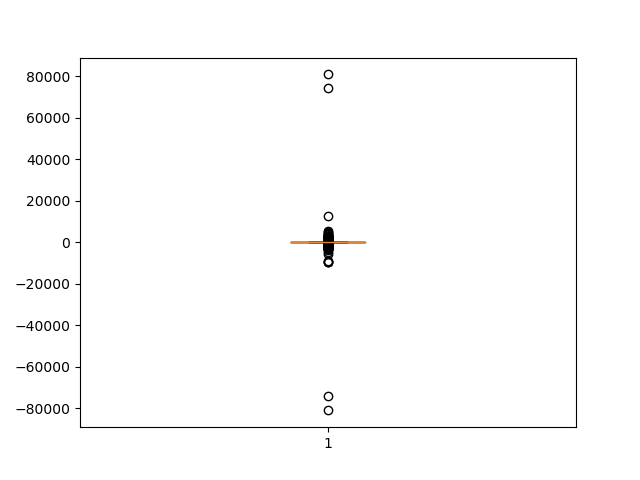

In [8]:
fig = plt.figure()
plt.boxplot(df0["Quantity"])
plt.show()

In [9]:
df0 = df0[(df0["Quantity"]<50000) & (df0["Quantity"]>-50000)] #remove outliers

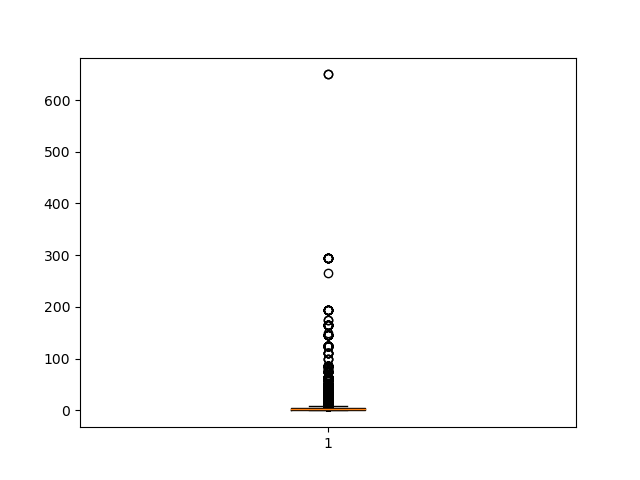

In [10]:
fig2 = plt.figure()
plt.boxplot(df0["UnitPrice"])
plt.show()

Analyze Country

In [11]:
df0["Country"] = df0["Country"].fillna("empty")
df0["Country"].value_counts()

United Kingdom          493886
Germany                   9096
France                    8236
EIRE                      8183
Spain                     2468
Netherlands               2330
Belgium                   1971
Switzerland               1969
Portugal                  1475
Australia                 1257
Norway                    1060
Italy                      783
Channel Islands            756
Finland                    653
Cyprus                     619
Unspecified                446
Sweden                     437
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
Israel                     297
USA                        291
Hong Kong                  280
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon 

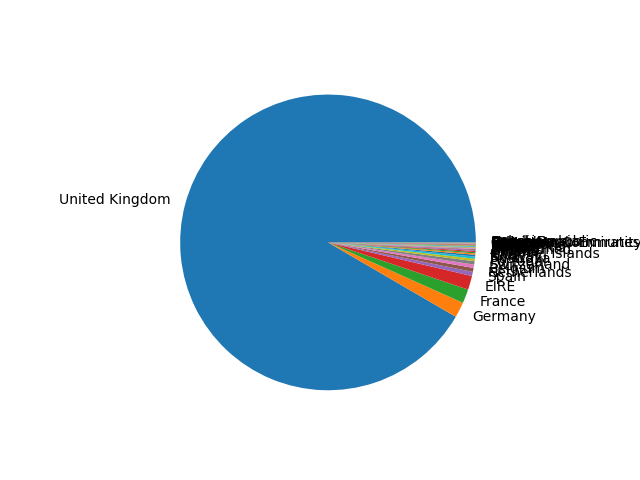

In [12]:
fig3 = plt.figure()
plt.pie(df0["Country"].value_counts(), labels = df0["Country"].value_counts().index)
plt.show()

In [13]:
df0 = df0[df0["Country"]=="United Kingdom"] #keep only data for the UK
df0.shape

(493886, 9)

### 3 - Forecasting
 The idea is to create a first simple model using only the amount sold by day to make a forecast

In [14]:
df1 = df0.iloc[:, 3:6] # I keep only the Quantity, Date and UnitPrice
df1.head()

,Quantity,InvoiceDate,UnitPrice
0,6,2010-12-01 08:26:00,2.55
1,6,2010-12-01 08:26:00,3.39
2,8,2010-12-01 08:26:00,2.75
3,6,2010-12-01 08:26:00,3.39
4,6,2010-12-01 08:26:00,3.39


In [15]:

df1["newDate"] = df1["InvoiceDate"].apply(lambda x : x. date() ) # keep only date and not time
del df1["InvoiceDate"]
df1.head()


,Quantity,UnitPrice,newDate
0,6,2.55,2010-12-01
1,6,3.39,2010-12-01
2,8,2.75,2010-12-01
3,6,3.39,2010-12-01
4,6,3.39,2010-12-01


In [16]:
# Compute price per product
df1["amount_per_product_type"] = df1["Quantity"] * df1["UnitPrice"]
del df1["Quantity"], df1["UnitPrice"]

# Group by Day
df2 = df1.groupby(['newDate']).sum()
df2 = df2.rename(columns={'amount_per_product_type': 'amount_per_day'})
df2.head()

,amount_per_day
newDate,
2010-12-01,53445.19
2010-12-02,46038.93
2010-12-03,38219.71
2010-12-05,25449.53
2010-12-06,49596.22


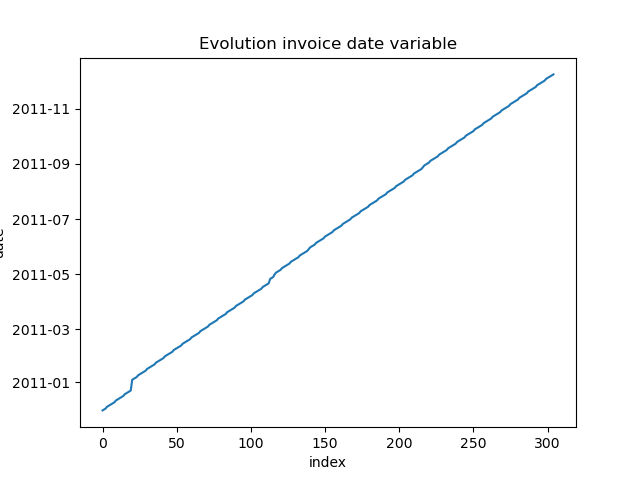

In [17]:
# explore date
fig4 = plt.figure()
plt.plot(df2.index)
plt.xlabel('index')
plt.ylabel('date')
plt.title('Evolution invoice date variable')
plt.show()

In [18]:
# remove data from 01 to 09 december 2010
df2["newDate"] = df2.index
df2 = df2.reset_index(drop=True)
df2 = df2.iloc[8:,:]
df2 = df2.reset_index(drop=True)

We are going to fill in the missing dates with an amount of 0 sales

In [19]:
all_days = pd.date_range(start="2010-12-10",end="2011-12-09") #create complete range of dates
all_days = all_days.to_series()
all_days = all_days.apply(lambda x : str(x) )
all_days = all_days.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date() )
all_days = all_days.reset_index(drop=True)
all_days = all_days.rename("newDate")

#join with our data
df_all_days = pd.DataFrame(all_days) 
df_all_days.index = df_all_days["newDate"]
del df_all_days["newDate"]

df2.index = df2["newDate"]
del df2["newDate"]

result = pd.concat([df2, df_all_days], axis=1, join="outer")
result["newDate"] = result.index
result = result.reset_index(drop=True)
final_df = result.sort_values(by=['newDate'], ascending=True)
final_df["amount_per_day"] = final_df["amount_per_day"].fillna(0) 
final_df = final_df.reset_index(drop=True)
final_df.head()


,amount_per_day,newDate
0,50882.79,2010-12-10
1,0.00,2010-12-11
2,13650.33,2010-12-12
3,35697.20,2010-12-13
4,40503.87,2010-12-14


Visualizations

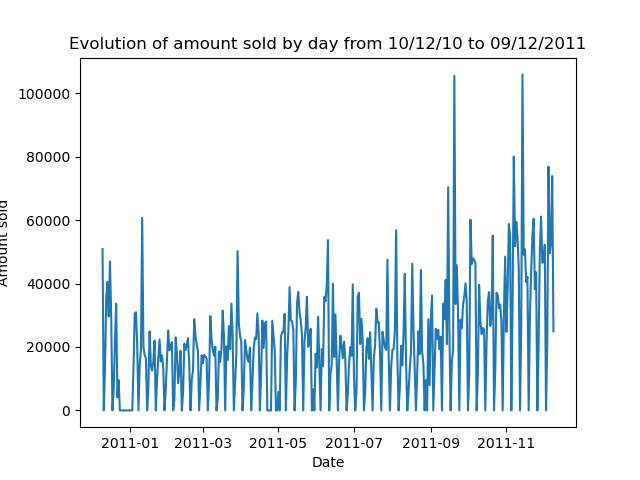

In [20]:
#Visualization of the time series
fig5 = plt.figure()
plt.plot(final_df["newDate"], final_df["amount_per_day"])
plt.xlabel('Date')
plt.ylabel('Amount sold')
plt.title('Evolution of amount sold by day from 10/12/10 to 09/12/2011')
plt.show()

In [21]:
#barchart per day of week
final_df["newDate"] = final_df["newDate"].apply(lambda x : datetime.strptime(str(x), '%Y-%m-%d'))
final_df["dayOfWeek"] = final_df["newDate"].apply(lambda x: x.weekday())
final_df[["amount_per_day", "dayOfWeek"]].groupby(['dayOfWeek']).mean()

,amount_per_day
dayOfWeek,
0,26199.716731
1,31116.194231
2,26281.698077
3,31148.218462
4,24278.710566
5,0.000000
6,13057.829231


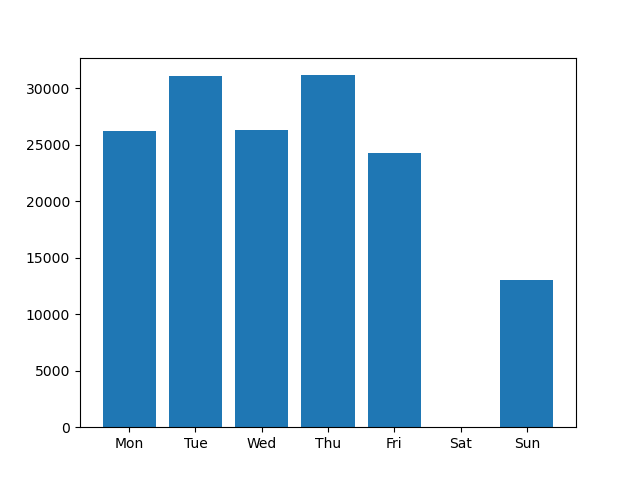

In [22]:
df_dow = final_df[["amount_per_day", "dayOfWeek"]].groupby(['dayOfWeek']).mean()
fig6 = plt.figure()
plt.bar(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], df_dow["amount_per_day"], align='center')
plt.show()

In [23]:
final_df["month"] = final_df["newDate"].apply(lambda x: x.month)
final_df[["amount_per_day", "month"]].groupby(['month']).mean()

,amount_per_day
month,
1,14745.074194
2,14785.903929
3,18170.482581
4,14524.240667
5,19710.537742
6,19816.416667
7,18311.903226
8,18156.651613
9,28748.372667


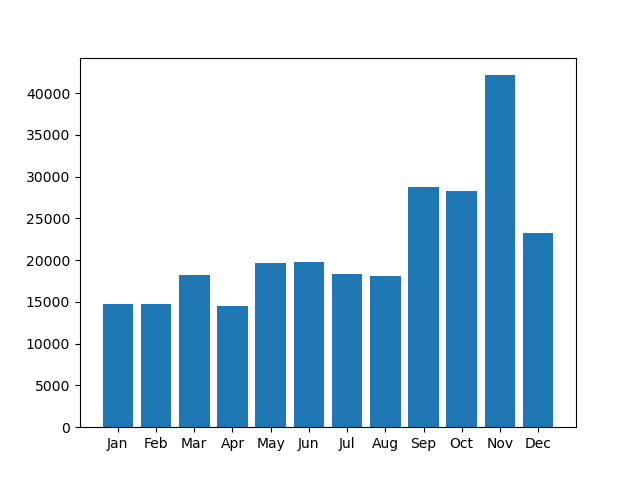

In [24]:
df_dom = final_df[["amount_per_day", "month"]].groupby(['month']).mean()
fig7 = plt.figure()
all_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(all_months, df_dom["amount_per_day"], align='center')
plt.show()

We agregate data by month and by week to better see the trends

In [25]:
df_dom["monthNum"] = df_dom.index
df_dom["monthDate"] = df_dom["monthNum"].apply(lambda x : datetime.strptime(str(x), '%m'))
from dateutil.relativedelta import relativedelta
df_dom["monthDate"] = df_dom["monthDate"].apply(lambda x : x+relativedelta(years=111))
df_dom.iloc[-1, -1] = df_dom.iloc[-1, -1] - relativedelta(years=1)
df_dom = df_dom.sort_values(by=['monthDate'])
df_dom.head()

,amount_per_day,monthNum,monthDate
month,,,
12,23273.526774,12,2010-12-01
1,14745.074194,1,2011-01-01
2,14785.903929,2,2011-02-01
3,18170.482581,3,2011-03-01
4,14524.240667,4,2011-04-01


In [26]:
#add week of year
final_df["weekNum"] = final_df["newDate"].apply(lambda x: x.isocalendar()[1])
df_woy = final_df[["amount_per_day", "weekNum"]].groupby(['weekNum']).mean()
df_woy["weekDate"] = datetime.strptime(str("2011-01-01"), '%Y-%m-%d')
for i in range(1, 52):
    df_woy.iloc[i, -1] = df_woy.iloc[i-1, -1] + relativedelta(days=7)
for i in range(49, 52):
    df_woy.iloc[i, -1] = df_woy.iloc[i, -1] - relativedelta(years=1)
df_woy = df_woy.sort_values(by=['weekDate'])
df_woy.head()

,amount_per_day,weekDate
weekNum,,
50,26967.565714,2010-12-10
51,9836.388571,2010-12-17
52,0.000000,2010-12-24
1,15734.800000,2011-01-01
2,20157.781429,2011-01-08


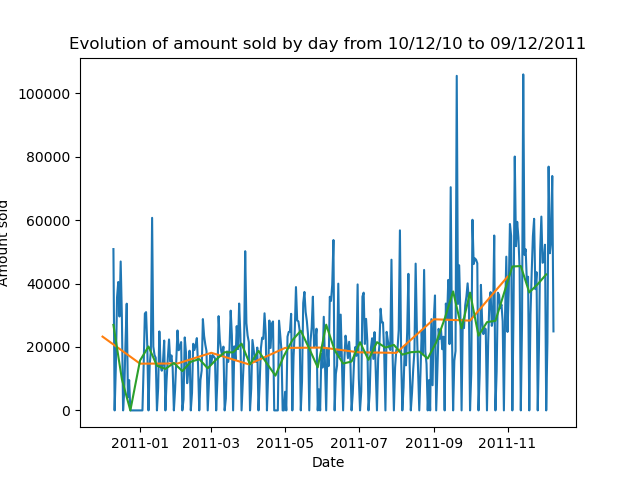

In [27]:
## add to graphic
fig9 = plt.figure()
plt.plot(final_df["newDate"], final_df["amount_per_day"])
plt.xlabel('Date')
plt.ylabel('Amount sold')
plt.title('Evolution of amount sold by day from 10/12/10 to 09/12/2011')
plt.plot(df_dom["monthDate"], df_dom["amount_per_day"])
plt.plot(df_woy["weekDate"], df_woy["amount_per_day"])
plt.show()

In [28]:
#Examine UK holidays
holidays = ["25/12/2010", "26/12/2010", "27/12/2010", "28/12/2010", "01/01/2011", "03/01/2011", "22/04/2011", "25/04/2011", "29/04/2011", "02/05/2011", "30/05/2011", "29/08/2011"]
holidays = [datetime.strptime(hol, '%d/%m/%Y').date() for hol in holidays]
holidayNames = ["Christmas", "Boxing", "Christmas Substitute", "Boxing Substitute", "New Year", "New Year Substitute", "Good Friday", "Easter Monday", "Royal Wedding", "Early May Bank", "Spring Bank", "August Bank"]

holiday_previous_day = ["23/12/2010", "21/04/2011", "28/04/2011", "27/05/2011", "26/08/2011"]
holiday_previous_day = [datetime.strptime(hol, '%d/%m/%Y').date() for hol in holiday_previous_day]


In [29]:
final_df["newDateObject"] = final_df["newDate"].apply(lambda x : x.date())
final_df.loc[final_df["newDateObject"].isin(holidays), :]

,amount_per_day,newDate,dayOfWeek,month,weekNum,newDateObject
15,0.0,2010-12-25,5,12,51,2010-12-25
16,0.0,2010-12-26,6,12,51,2010-12-26
17,0.0,2010-12-27,0,12,52,2010-12-27
18,0.0,2010-12-28,1,12,52,2010-12-28
22,0.0,2011-01-01,5,1,52,2011-01-01
24,0.0,2011-01-03,0,1,1,2011-01-03
133,0.0,2011-04-22,4,4,16,2011-04-22
136,0.0,2011-04-25,0,4,17,2011-04-25
140,0.0,2011-04-29,4,4,17,2011-04-29
143,0.0,2011-05-02,0,5,18,2011-05-02


In [30]:
# Examine days previous to holidays
final_df.loc[final_df["newDateObject"].isin(holiday_previous_day), :]

,amount_per_day,newDate,dayOfWeek,month,weekNum,newDateObject
13,9555.79,2010-12-23,3,12,51,2010-12-23
132,28057.11,2011-04-21,3,4,16,2011-04-21
139,19004.85,2011-04-28,3,4,17,2011-04-28
168,25766.17,2011-05-27,4,5,21,2011-05-27
259,14707.30,2011-08-26,4,8,34,2011-08-26


In [31]:
#Compare the difference between normal difference of sales between Thu and Fri and difference of those days
print("Usual gap Fri-Thu:", 24278.710566 - 31148.218462)
print("Gap between 27/05 and 26/05:", 25766.17	 - 21877.79)
print("Gap between 26/08 and 25/08:", 14707.30 - 18556.15)


# normal difference of sales between Thu and Wed
print("Usual gap Thu-Wed:", 31148.218462 - 26281.698077)
print("Gap between 23/12 and 22/12:", 9555.79 - 4125.05)
print("Gap between 21/04 and 20/04:", 28057.11 - 27352.23)
print("Gap between 28/04 and 27/04:", 19004.85 - 23541.76)

prev1 = datetime.strptime("27/04/2011", '%d/%m/%Y').date() 
final_df.loc[final_df["newDateObject"]==prev1, :]


Usual gap Fri-Thu: -6869.507895999999
Gap between 27/05 and 26/05: 3888.3799999999974
Gap between 26/08 and 25/08: -3848.850000000002
Usual gap Thu-Wed: 4866.520385
Gap between 23/12 and 22/12: 5430.740000000001
Gap between 21/04 and 20/04: 704.880000000001
Gap between 28/04 and 27/04: -4536.91


,amount_per_day,newDate,dayOfWeek,month,weekNum,newDateObject
138,23541.76,2011-04-27,2,4,17,2011-04-27


### 4 - Predicting

We are going to be using the Prophet library

In [32]:
final_df = final_df[['amount_per_day', 'newDate']]
final_df.columns = ['y', 'ds']
final_df = final_df[['ds', 'y']]
final_df.head()

,ds,y
0,2010-12-10,50882.79
1,2010-12-11,0.00
2,2010-12-12,13650.33
3,2010-12-13,35697.20
4,2010-12-14,40503.87


We will first train with 90% of the data and test it on the remaining 10%.

In [33]:
l = int(0.9 * final_df.shape[0])
df_train = final_df.iloc[:l, :]
print(df_train.tail())
df_test = final_df.iloc[l:, :]
print(df_test.shape)


            ds         y
323 2011-10-29      0.00
324 2011-10-30  30547.63
325 2011-10-31  48490.68
326 2011-11-01  24744.69
327 2011-11-02  37752.95
(37, 2)


We first decompose the series to extract the trend and the seasonalities.

16:59:03 - cmdstanpy - INFO - Chain [1] start processing
16:59:03 - cmdstanpy - INFO - Chain [1] done processing


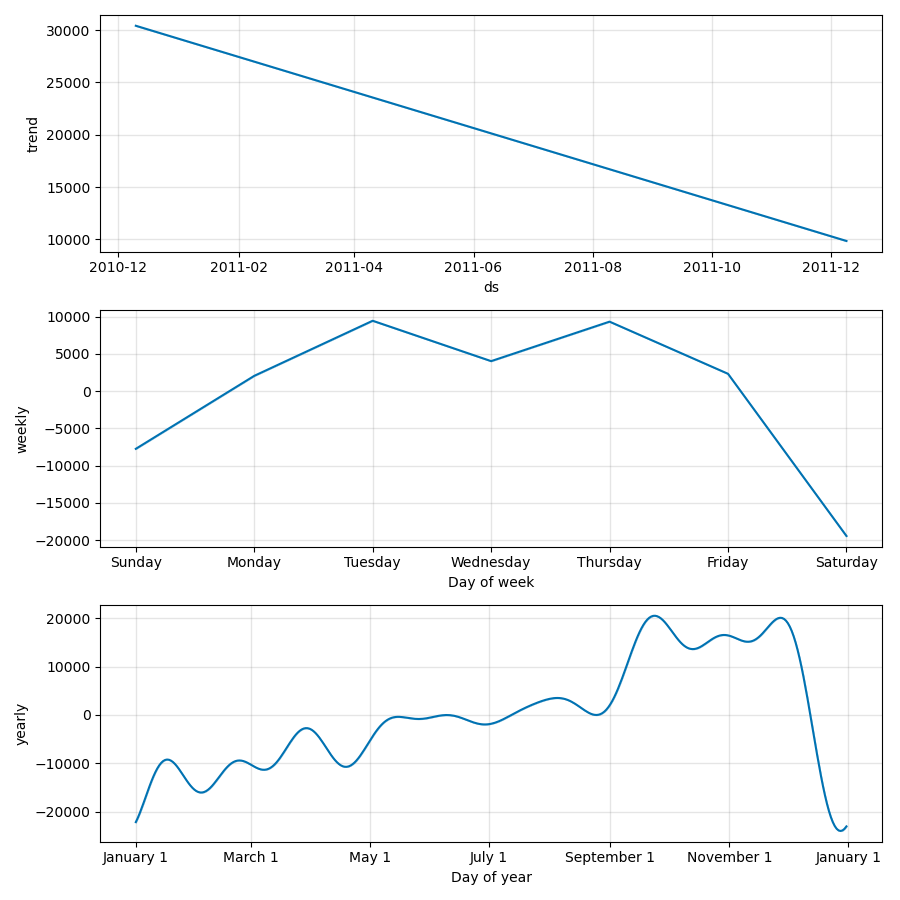

In [34]:
m = Prophet(
    daily_seasonality=False
    , weekly_seasonality=True
    , yearly_seasonality=True
)
m.fit(df_train)

future = m.make_future_dataframe(periods=37, freq='D', include_history=True)
forecast = m.predict(future)

# plot the different components of the Prophet analysis
fig10 = m.plot_components(forecast)

16:59:04 - cmdstanpy - INFO - Chain [1] start processing
16:59:04 - cmdstanpy - INFO - Chain [1] done processing


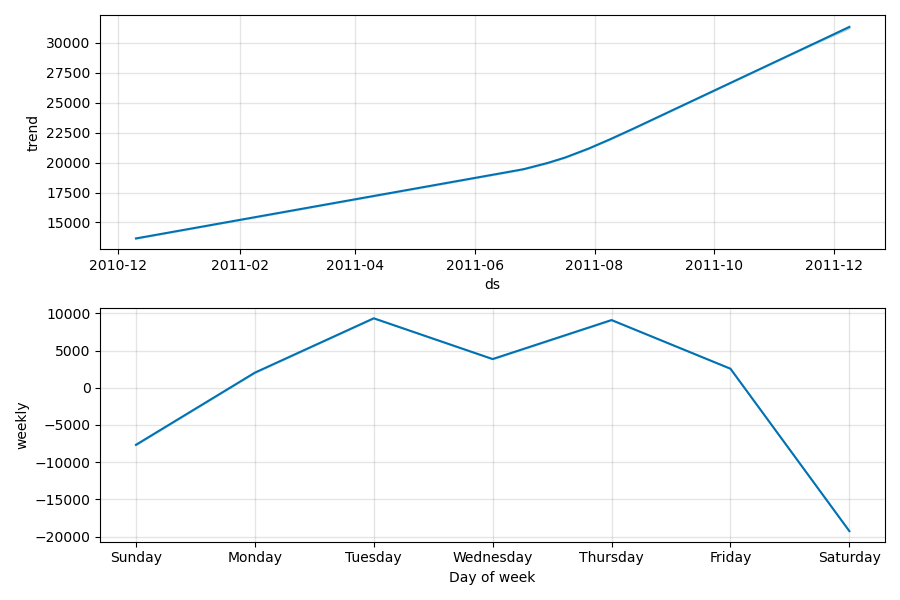

In [35]:
m = Prophet(
    daily_seasonality='auto'
    , weekly_seasonality='auto'
    , yearly_seasonality='auto'
)
m.fit(df_train)
future = m.make_future_dataframe(periods=37, freq='D', include_history=True)
forecast = m.predict(future)

# plot the different components of the Prophet analysis
fig11 = m.plot_components(forecast)

We now compute the predictions and visuaize them.

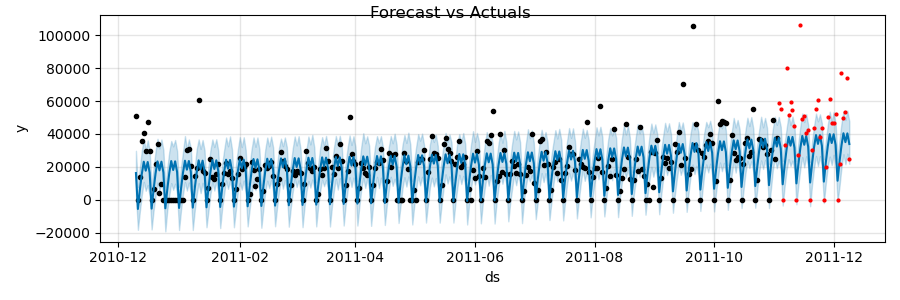

In [36]:
# plot a subset of the sample
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(9)
fig = m.plot(forecast, ax=ax)
plot = plt.suptitle('Forecast vs Actuals')
plt.plot(df_test["ds"], df_test["y"], 'ro', markersize=2)

In [37]:
#Evaluate predictions
startTime = df_test["ds"].min()
predictions = forecast[forecast["ds"]>=startTime]
rmse = math.sqrt(mean_squared_error(df_test["y"], predictions["yhat"]))
mae = mean_absolute_error(df_test["y"], predictions["yhat"])
print("RMSE is:", rmse)
print("MAE is:", mae)


RMSE is: 21877.381889962744
MAE is: 16668.609237811816


In [38]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
328,2011-11-03,28537.699154,23737.293514,50304.654488,28537.699154,28537.699154,9113.353164,9113.353164,9113.353164,9113.353164,9113.353164,9113.353164,0.0,0.0,0.0,37651.052318
329,2011-11-04,28614.655845,18709.460098,44404.756667,28614.655845,28614.655845,2570.564727,2570.564727,2570.564727,2570.564727,2570.564727,2570.564727,0.0,0.0,0.0,31185.220571
330,2011-11-05,28691.612535,-3505.563274,23554.794940,28691.180118,28691.899077,-19268.252655,-19268.252655,-19268.252655,-19268.252655,-19268.252655,-19268.252655,0.0,0.0,0.0,9423.359880
331,2011-11-06,28768.569226,8377.435497,34767.335255,28767.274650,28769.469357,-7669.632211,-7669.632211,-7669.632211,-7669.632211,-7669.632211,-7669.632211,0.0,0.0,0.0,21098.937015
332,2011-11-07,28845.525917,18151.082239,43234.067891,28843.113795,28847.513183,2036.866589,2036.866589,2036.866589,2036.866589,2036.866589,2036.866589,0.0,0.0,0.0,30882.392505


In [39]:
# Adjust for Saturdays and holidays previous days
adjustedPredictions = predictions[["ds", "yhat"]]
adjustedPredictions["dayOfWeek"] = adjustedPredictions["ds"].apply(lambda x: x.weekday())
adjustedPredictions.loc[adjustedPredictions["dayOfWeek"]==5, "yhat"] = 0
adjustedPredictions.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 328 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      37 non-null     datetime64[ns]
 1   yhat    37 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 888.0 bytes


In [43]:
#Evaluate predictions
startTime = df_test["ds"].min()
rmse = math.sqrt(mean_squared_error(df_test["y"], adjustedPredictions["yhat"]))
mae = mean_absolute_error(df_test["y"], adjustedPredictions["yhat"])
print("RMSE is:", rmse)
print("MAE is:", mae)

RMSE is: 21532.315720720002
MAE is: 15249.588487906003


Use whole dataset to learn and forecast on the next 365 days

17:10:26 - cmdstanpy - INFO - Chain [1] start processing
17:10:26 - cmdstanpy - INFO - Chain [1] done processing


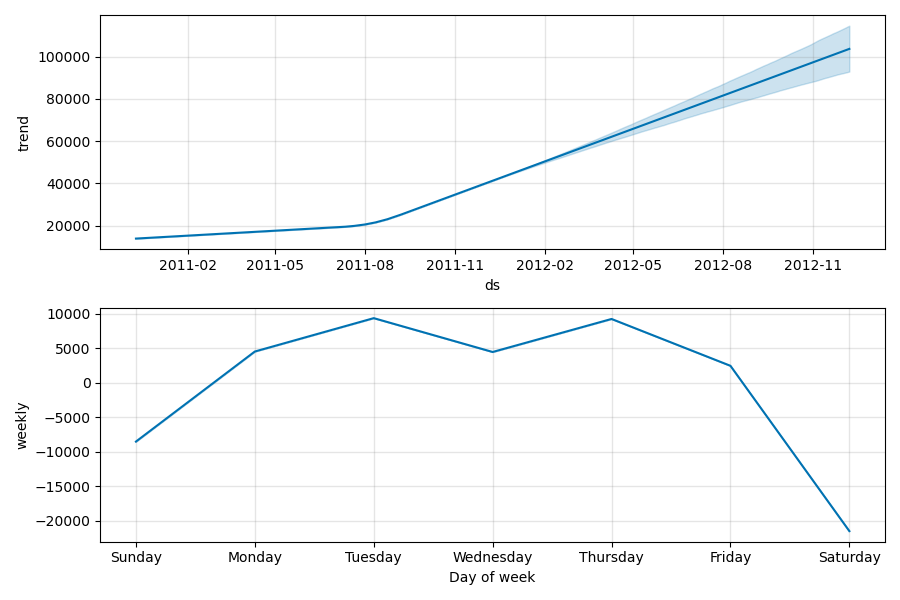

In [45]:
m = Prophet(
    daily_seasonality='auto'
    , weekly_seasonality='auto'
    , yearly_seasonality='auto'
)
m.fit(final_df)

future = m.make_future_dataframe(periods=365, freq='D', include_history=True)
forecast = m.predict(future)

# plot the different components of the Prophet analysis
fig10 = m.plot_components(forecast)

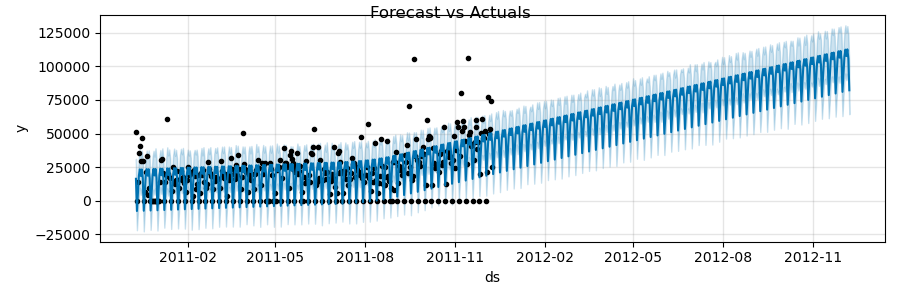

In [48]:
# plot a subset of the sample
f, ax = plt.subplots(1)
f.set_figheight(3)
f.set_figwidth(9)
fig = m.plot(forecast, ax=ax)
plot = plt.suptitle('Forecast vs Actuals')

In [49]:
# Adjust for Saturdays and holidays previous days
adjustedPredictions = forecast[["ds", "yhat"]]
adjustedPredictions["dayOfWeek"] = adjustedPredictions["ds"].apply(lambda x: x.weekday())
adjustedPredictions.loc[adjustedPredictions["dayOfWeek"]==5, "yhat"] = 0
adjustedPredictions.head()

C:\Users\mararamb\AppData\Local\Temp\ipykernel_2940\484476675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjustedPredictions["dayOfWeek"] = adjustedPredictions["ds"].apply(lambda x: x.weekday())


,ds,yhat,dayOfWeek
0,2010-12-10,16359.135525,4
1,2010-12-11,0.000000,5
2,2010-12-12,5415.451606,6
3,2010-12-13,18509.315854,0
4,2010-12-14,23377.394330,1
5,2010-12-15,18493.003331,2
6,2010-12-16,23310.045342,3
7,2010-12-17,16541.205893,4
8,2010-12-18,0.000000,5
9,2010-12-19,5597.521974,6


In [51]:
adjustedPredictions.to_csv("predictions.csv")